In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

from tqdm import tqdm 
import h5py

In [2]:
lr_list = np.array([np.power(0.5, i) for i in range(2, 16, 2)])
lr_ary = np.array([np.power(0.5, i) for i in range(2, 16, 2)]*10)

In [3]:
lr_ary[list(range(0,70,7))]

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

In [5]:
file_dir = '/Users/qingyao/../../Volumes/Seagate_Qing/branching_data/gnn_regression_2d5/including_large_r/'

In [6]:
def find_best_learning_rate_and_test_mse(file_dir, x_number, slipt, lr_list, g=True):
    if g:
        sub_dir = 'regression_{}' .format(x_number)
    else:
        sub_dir = 'regression_ng_{}' .format(x_number)
#     print(sub_dir)
    RES = np.zeros((10, 7))
    for lr_idx in range(70):
        with h5py.File(file_dir+sub_dir+'/res_{}_{}.hdf5'.format( slipt, lr_idx), 'r') as f:
            lr_pos = lr_idx % 7
            run = lr_idx // 7
            val_loss = f['val_mse'][()]
            RES[run, lr_pos] = val_loss[-1]
#     print(RES)
    min_positions = np.argmin(RES, axis=1)
    index_counts = np.bincount(min_positions)
    most_frequent_index = np.argmax(index_counts)
    
    test_mse_best = np.infty
    test_mse_position = 0
    for lr_idx in range(most_frequent_index, 70, 7):
        with h5py.File(file_dir+sub_dir+'/res_{}_{}.hdf5'.format(slipt, lr_idx), 'r') as f:
            test_mse = f['test_mse'][()]
            if test_mse < test_mse_best:
                test_mse_best = test_mse
                test_mse_position = lr_idx

    return test_mse_best, lr_list[most_frequent_index], test_mse_position

In [7]:
x_num_list = list(range(7,49,7)) + [50]
x_num_list

[7, 14, 21, 28, 35, 42, 50]

In [8]:
test_lr_g = np.zeros((7,10,3))
for x_number_idx in range(len(x_num_list)):
    x_number = x_num_list[x_number_idx]
    for slipt_idx in range(10):
        temp0, temp1,temp2 = find_best_learning_rate_and_test_mse(file_dir, x_number, slipt_idx, lr_list)
        test_lr_g[x_number_idx, slipt_idx, 0] =  temp0
        test_lr_g[x_number_idx, slipt_idx, 1] =  temp1
        test_lr_g[x_number_idx, slipt_idx, 2] =  temp2
mse_test_g = test_lr_g[:,:,0]
mse_avg_g = np.mean(mse_test_g,axis=1)
mse_std_g = np.std(mse_test_g,axis=1)

In [9]:
test_lr = np.zeros((7,10,3))
for x_number_idx in range(len(x_num_list)):
    x_number = x_num_list[x_number_idx]
    for slipt_idx in range(10):
        temp0, temp1,temp2 = find_best_learning_rate_and_test_mse(file_dir, x_number, slipt_idx, lr_list, False)
        test_lr[x_number_idx, slipt_idx, 0] =  temp0
        test_lr[x_number_idx, slipt_idx, 1] =  temp1
        test_lr[x_number_idx, slipt_idx, 2] =  temp2
mse_test = test_lr[:,:,0]
mse_avg = np.mean(mse_test,axis=1)
mse_std = np.std(mse_test,axis=1)

In [10]:
mse_avg

array([1.30942377, 0.66096933, 0.48306545, 0.4100558 , 0.38235242,
       0.36886406, 0.21925719])

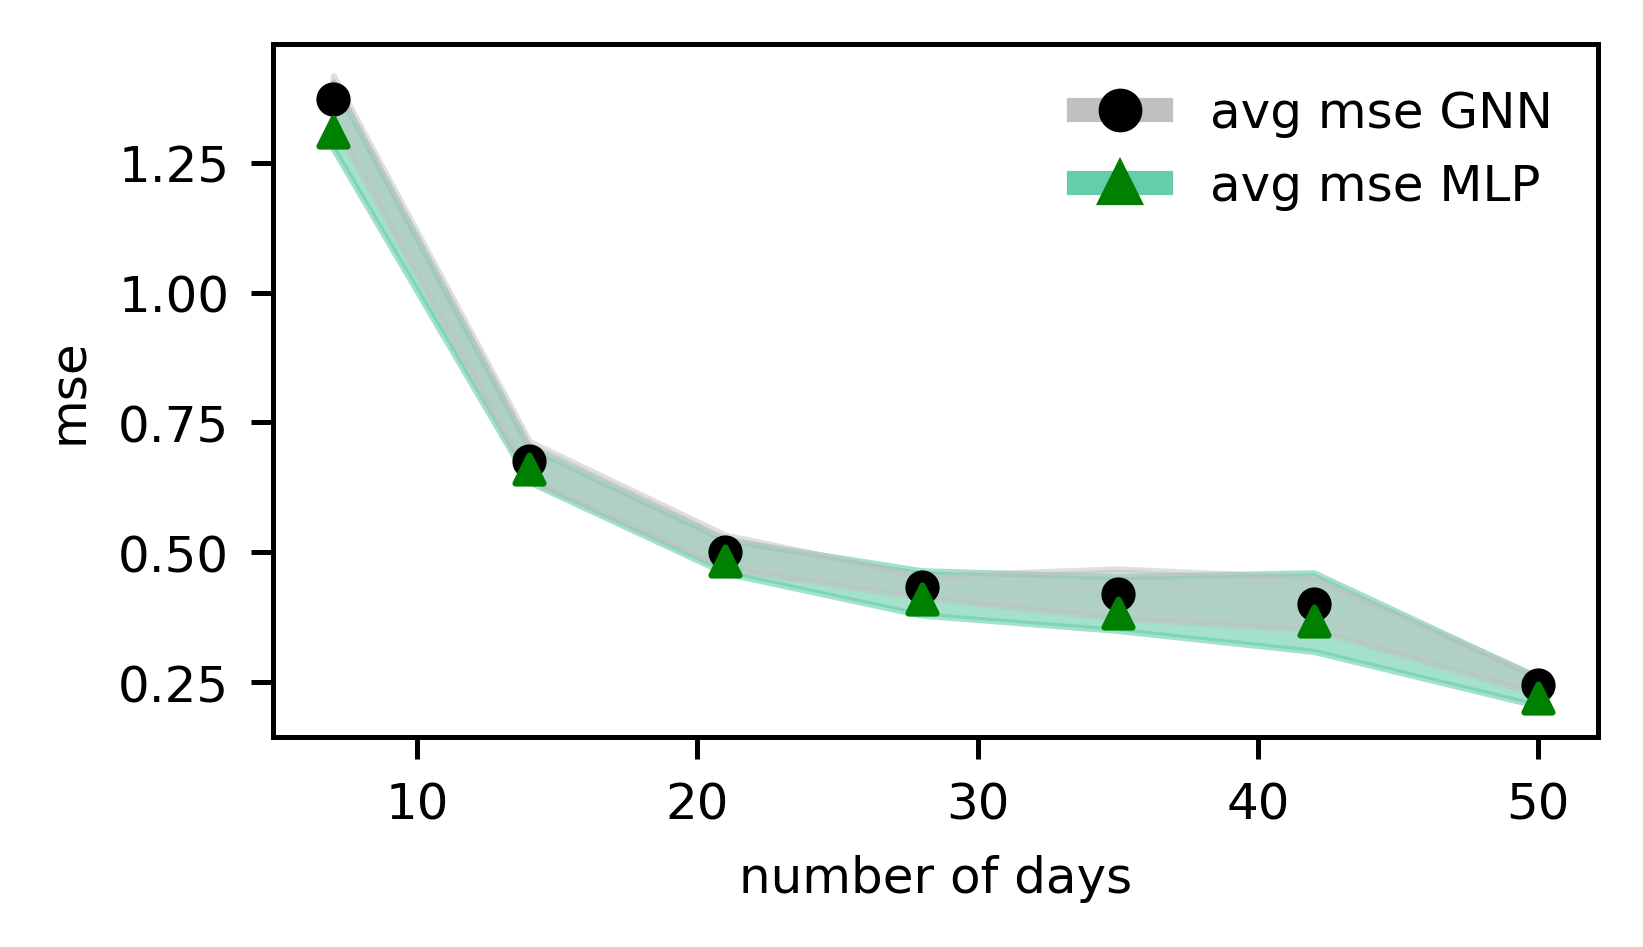

In [12]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(3.8,2.),dpi=450)
# plt.scatter(rs,np.array(Bootstrap_mean),label='test')

plt.fill_between(x_num_list,mse_avg-mse_std,mse_avg_g+mse_std,alpha=0.6,color='mediumaquamarine')
plt.fill_between(x_num_list,mse_avg_g-mse_std_g,mse_avg_g+mse_std_g,alpha=0.5,color='silver')


scatter_g = plt.scatter(x_num_list,mse_avg_g,label='avg mse in the test set (with graph)',
            color='black',s=20)
scatter_ng = plt.scatter(np.array(x_num_list),mse_avg,label='avg mse in the test set (without graph)',
            c='green',s=20,marker='^')

# Custom legend handlers
class CustomHandlerG:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle([x0, y0 + height*0.25], width, height*0.5, color='silver', alpha=1, transform=handlebox.get_transform())
        dot = mlines.Line2D([x0 + width*0.5], [y0 + height*0.5], linestyle='none', marker='o', color='black', transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        handlebox.add_artist(dot)
        return [patch, dot]

class CustomHandlerNG:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle([x0, y0 + height*0.25], width, height*0.5, color='mediumaquamarine', alpha=1, transform=handlebox.get_transform())
        dot = mlines.Line2D([x0 + width*0.5], [y0 + height*0.5], linestyle='none', marker='^', color='green', transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        handlebox.add_artist(dot)
        return [patch, dot]

# Create legend
plt.legend([scatter_g, scatter_ng], 
           ['avg mse GNN', 'avg mse MLP'], 
           handler_map={scatter_g: CustomHandlerG(), scatter_ng: CustomHandlerNG()}, 
           loc='best',frameon=False,fontsize=8)

plt.xlabel('number of days',size=8)
plt.ylabel('mse',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.legend(frameon=False,fontsize=8)
plt.savefig("mlp_vs_gnn.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig('mlp_vs_gnn.eps',bbox_inches='tight',format='eps')